### Install dependencies

In [3]:
!pip install stable-baselines3[extra] protobuf==3.20.*

  Using cached stable_baselines3-1.8.0-py3-none-any.whl (174 kB)
  Using cached gym-0.21.0-py3-none-any.whl
  Using cached cloudpickle-2.2.1-py3-none-any.whl (25 kB)
  Using cached importlib_metadata-4.13.0-py3-none-any.whl (23 kB)
                                              0.0/5.6 MB ? eta -:--:--
                                              0.0/5.6 MB ? eta -:--:--
                                              0.0/5.6 MB 393.8 kB/s eta 0:00:15
     --                                       0.4/5.6 MB 3.0 MB/s eta 0:00:02
     ------                                   0.9/5.6 MB 5.1 MB/s eta 0:00:01
     ---------                                1.4/5.6 MB 6.2 MB/s eta 0:00:01
     -------------                            1.9/5.6 MB 7.3 MB/s eta 0:00:01
     -----------------                        2.5/5.6 MB 8.0 MB/s eta 0:00:01
     -----------------------                  3.2/5.6 MB 9.0 MB/s eta 0:00:01
     ----------------------------             3.9/5.6 MB 9.7 MB/s eta 0:00:01


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
label-studio 1.7.3 requires google-auth==2.11.0, but you have google-auth 2.19.1 which is incompatible.
label-studio 1.7.3 requires jsonschema==3.2.0, but you have jsonschema 4.17.3 which is incompatible.
label-studio 1.7.3 requires python-dateutil==2.8.1, but you have python-dateutil 2.8.2 which is incompatible.


In [4]:
!pip install mss pydirectinput pytesseract

  Using cached pytesseract-0.3.10-py3-none-any.whl (14 kB)


### Import library

In [1]:
# use for screen capture
from mss import mss 
# sending command
import pydirectinput 
import cv2
import numpy as np
# OCR for game over extraction
import pytesseract
from matplotlib import pyplot as plt
import time
# environment component
from gym import Env
from gym.spaces import Box, Discrete

In [2]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

### Build enviroment

#### Create environment

In [3]:
# create environment
class WebGame(Env):
    # setup the environment action and observation shapes
    def __init__(self):
        # sub class model
        super().__init__()
        # setup spaces
        self.observation_space = Box(low=0, high=255, shape=(1,83,100), dtype=np.uint8)
        self.action_space = Discrete(3) # 3 is total of action that we need. 
        # define extraction parameters for the game
        self.cap = mss()
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500}
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70}
    # call to do something in the game
    def step(self, action):
        # action key - 0=space, 1=duck(down), 2=No action (no op)
        action_map = {
            0:'space',
            1:'down',
            3:'no_op'
        } 
        if action != 2:
            pydirectinput.press(action_map[action])
        
        # checking whether the game is done
        done, done_cap = self.get_done()
        new_observation = self.get_observation()
        
        # reward for every frame are alive
        reward = 1
        # info dictionary
        info = {}

        return new_observation, reward, done, info 

    # visualize the game
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()
            
    # this closes donw the observation
    def close(self):
        cv2.destroyAllWindows() 

    # restart the game
    def reset(self):
        time.sleep(1)
        pydirectinput.click(x=150, y=150)
        pydirectinput.press('space')
        return self.get_observation() 

    # get the part of the observation the game that we want
    def get_observation(self):
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (100,83))
        channel = np.reshape(resized, (1,83,100)) # add channel first
        return channel 
    
    # get the done text (Game Over)
    def get_done(self):
        # get done screen
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # valid done text
        done_strings = ['GAME', 'GAHE']

        # OCR text
        done = False 
        res = pytesseract.image_to_string(done_cap)[:4]
        if res in done_strings:
            done = True 
        
        return done, done_cap

In [27]:
env = WebGame()

In [31]:
env.reset()

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]]], dtype=uint8)

In [33]:
env.render()

In [34]:
env.close()

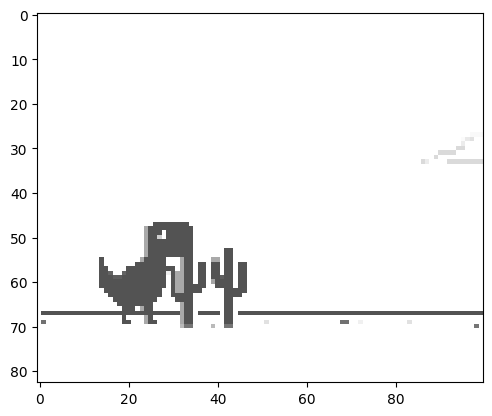

In [83]:
obs=env.get_observation()
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_GRAY2BGR))

In [100]:
done, done_cap = env.get_done()

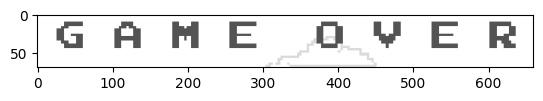

In [101]:
plt.imshow(done_cap)

In [104]:
done 

True

#### Test environment

In [35]:
# play 10 times
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, done, info = env.step(env.action_space.sample())
        total_reward+=reward
    print(f"Total reward for episode {episode} is {total_reward}")

Total reward for episode 0 is 14
Total reward for episode 1 is 13
Total reward for episode 2 is 17
Total reward for episode 3 is 15
Total reward for episode 4 is 17
Total reward for episode 5 is 15
Total reward for episode 6 is 11
Total reward for episode 7 is 36
Total reward for episode 8 is 17
Total reward for episode 9 is 15


### Train model

#### Create callback

In [4]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [37]:
env_checker.check_env(env)

In [38]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [39]:
CHECKPOINT_DIR = './train/'
LOG_DIR = './logs/'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

In [40]:
callback = TrainAndLoggingCallback(check_freq=1000, save_path=CHECKPOINT_DIR)

#### Build DQN and train

In [5]:
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack

In [42]:
env = WebGame()

In [43]:
model = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, 
            buffer_size=1200000, learning_starts=1000)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\babyt\miniconda3\envs\pt\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 4.03GB
  warnings.warn(


In [44]:
model.learn(total_timesteps=5000, callback=callback)  

Logging to ./logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 18.5     |
|    ep_rew_mean      | 18.5     |
|    exploration_rate | 0.859    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 43       |
|    total_timesteps  | 74       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 22.1     |
|    ep_rew_mean      | 22.1     |
|    exploration_rate | 0.664    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 99       |
|    total_timesteps  | 177      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 20.8     |
|    ep_rew_mean      | 20.8     |
|    exploration_rate | 0.527    |
| time/               |        

In [6]:
## restart kernel and run again to load model (full ram)
model = DQN.load(os.path.join('train','best_model_88000'))

c:\Users\babyt\miniconda3\envs\pt\lib\site-packages\stable_baselines3\common\buffers.py:229: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 19.94GB > 3.19GB
  warnings.warn(


### Test model

In [7]:
model 

In [8]:
env = WebGame()
for episode in range(10):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, info = env.step(int(action))
        total_reward+=reward
    print(f"Total reward for episode {episode} is {total_reward}")

Total reward for episode 0 is 31
Total reward for episode 1 is 37
Total reward for episode 2 is 137
Total reward for episode 3 is 99
Total reward for episode 4 is 200
Total reward for episode 5 is 89
Total reward for episode 6 is 101
Total reward for episode 7 is 76
Total reward for episode 8 is 132
Total reward for episode 9 is 64
